# 网络的验证

这种验证其实也就有些类似于目标检测的验证了，比分类问题复杂些，通过一些指标而非简单的分类标签来判定真伪。

如果先不看ggcnn中的思路，这块让我来做的话，分析一下，我们得到的网络输出是pos_img,ang_img和width_img，pos_img各点的值可以视作该点可抓不可抓的概率，图像大小为（300，300），太多了，那么我首先可以把最大值的1000个点筛选出来，然后找对对应的angle和width，凭借这三个参数就可以重建出这些点的抓取框，然后计算与真实各框的iou和jaccard指数等，如果都满足标准，就认为这是一次正确的抓取，这次预测也就是正确的了。

那就开整，流程应该是这样的：
- 首先是从网络的输出映射图中反求出各个实际参数代表的抓取框，主要就是要将cos和sin两个图反求出angle。
- 然后要明确一下成功的标准，然后写函数计算这些标准，最后再集成到类或者函数里面，思路还是很明确的。
  - 1.IoU
  - 2.jaccard index

## 1.数据的反求

首先是通过原始的输出映射四张图把数据读出来，这边我们先运行一个训练，得到一下训练输出，然后方便处理

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from train.cornell_pro import Cornell
from train.ggcnn import GGCNN

#准备数据集
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break
    
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#为了能够看出效果，就在这个样本上多训练几次，得到一个很擅长这个样本的模型，然后拿它做预测输出

for i in range(50):
    losses = net.compute_loss(xc,yc)
    
    loss = losses['loss']
    print(i,loss)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()



0 tensor(0.8671, grad_fn=<AddBackward0>)
1 tensor(0.8464, grad_fn=<AddBackward0>)
2 tensor(0.8241, grad_fn=<AddBackward0>)
3 tensor(0.7986, grad_fn=<AddBackward0>)
4 tensor(0.7668, grad_fn=<AddBackward0>)
5 tensor(0.7249, grad_fn=<AddBackward0>)
6 tensor(0.6672, grad_fn=<AddBackward0>)
7 tensor(0.5866, grad_fn=<AddBackward0>)
8 tensor(0.4791, grad_fn=<AddBackward0>)
9 tensor(0.3506, grad_fn=<AddBackward0>)
10 tensor(0.2276, grad_fn=<AddBackward0>)
11 tensor(0.1765, grad_fn=<AddBackward0>)
12 tensor(0.2575, grad_fn=<AddBackward0>)
13 tensor(0.2411, grad_fn=<AddBackward0>)
14 tensor(0.1598, grad_fn=<AddBackward0>)
15 tensor(0.1062, grad_fn=<AddBackward0>)
16 tensor(0.0981, grad_fn=<AddBackward0>)
17 tensor(0.1126, grad_fn=<AddBackward0>)
18 tensor(0.1276, grad_fn=<AddBackward0>)
19 tensor(0.1335, grad_fn=<AddBackward0>)
20 tensor(0.1287, grad_fn=<AddBackward0>)
21 tensor(0.1158, grad_fn=<AddBackward0>)
22 tensor(0.1005, grad_fn=<AddBackward0>)
23 tensor(0.0899, grad_fn=<AddBackward0>)
24

In [2]:
#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

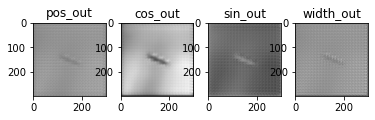

In [3]:
#看一下是否能够给出一个相对合理的预测
num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()
#看起来还不错，下面开始数据的读取和反求

In [4]:
print(pos.shape)
print(cos.shape)
print(sin.shape)
print(width.shape)

torch.Size([32, 1, 300, 300])
torch.Size([32, 1, 300, 300])
torch.Size([32, 1, 300, 300])
torch.Size([32, 1, 300, 300])


In [5]:
q_img = pos.data.numpy().squeeze()
ang_img = (torch.atan2(sin, cos) / 2.0).data.numpy().squeeze()
width_img = width.data.numpy().squeeze()

In [6]:
#squeeze的作用通过前后的shape就可以看出来，对于单通道的图像，可视化以及后面计算的时候是不要需要第三个维度的，所以去掉了
print(q_img.shape)
print(ang_img.shape)
print(width_img.shape)

(32, 300, 300)
(32, 300, 300)
(32, 300, 300)


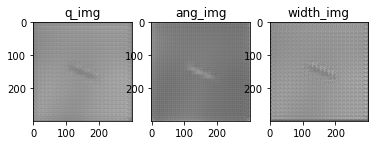

In [7]:
#可视化一下看看效果

num = 20

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img[num],cmap=plt.cm.gray)
plt.show()

在真正计算之前，还需要进行一个高斯滤波，原因论文中已经说过了，前面与已经可视化了滤波之前的效果，后面滤波一下，然后再看效果

In [8]:
from skimage.filters import gaussian
q_img_g = gaussian(q_img, 2.0, preserve_range=True)
ang_img_g = gaussian(ang_img, 2.0, preserve_range=True)
width_img_g = gaussian(width_img, 1.0, preserve_range=True)

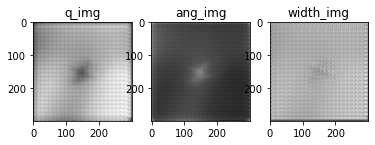

In [9]:
#可视化一下看看效果

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img_g[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img_g[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img_g[num],cmap=plt.cm.gray)
plt.show()

为什么会出现十字的效果？？？新出现的垂直于原始走向的那部分明显不符合要求啊。

测试一下这个函数看看是怎么回事

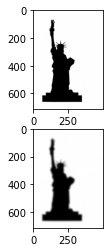

In [10]:
import cv2

img = cv2.imread('images/test_guassian.jpg',0)
img_guassian = gaussian(img, 5.0, preserve_range=True)

plt.subplot(211)
plt.imshow(img,cmap=plt.cm.gray)
plt.subplot(212)
plt.imshow(img_guassian,cmap=plt.cm.gray)
plt.show()

挺好的啊，在这个图像上面就是简单地模糊了一下，为什么在原来的图像上却出现了十字。

下面用opencv的函数试一下高斯滤波

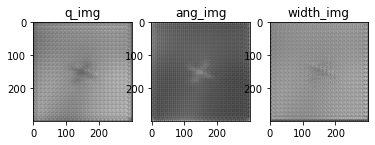

In [11]:
import cv2

q_img = cv2.GaussianBlur(q_img,(3,3),0)
ang_img = cv2.GaussianBlur(ang_img,(3,3),0)
width_img = cv2.GaussianBlur(width_img,(3,3),0)

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img[num],cmap=plt.cm.gray)
plt.show()

同样出现了类似的十字，说明应该是img的问题而不是函数的问题，那么下面用一下ggcnn原始的网络输出试一下，通过载入一个训练好的模型，用它计算输出来实现。

In [42]:
with open('validate/trained_model','rb') as f:
    a = f.read()

FileNotFoundError: [Errno 2] No such file or directory: 'validate/trained_model'

In [38]:
a[0:100]

b'\x80\x02\x8a\nl\xfc\x9cF\xf9 j\xa8P\x19.\x80\x02M\xe9\x03.\x80\x02}q\x00(X\x10\x00\x00\x00protocol_versionq\x01M\xe9\x03X\r\x00\x00\x00little_endianq\x02\x88X\n\x00\x00\x00type_sizesq\x03}q\x04(X\x05\x00\x00\x00'

In [41]:
#载入训练好的模型
net = torch.load('validate/epoch_05_iou_0.72')

ModuleNotFoundError: No module named 'models'

In [ ]:
#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

#可视化一下结果
num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()

In [ ]:
q_img = pos.data.numpy().squeeze()
ang_img = (torch.atan2(sin, cos) / 2.0).data.numpy().squeeze()
width_img = width.data.numpy().squeeze()

#可视化一下看一下这次的效果

plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img_g[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img_g[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img_g[num],cmap=plt.cm.gray)
plt.show()

## 2.标准的确定
### 2.1 IoU的计算
全称Intersection over Union
![IoU计算示意图](images/iou.png)

计算IoU程序的设计思路可以参考：https://blog.csdn.net/u014061630/article/details/82818112